In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

sns.set_style('white')
sns.set_context('poster')

In [2]:
print('hi')

hi


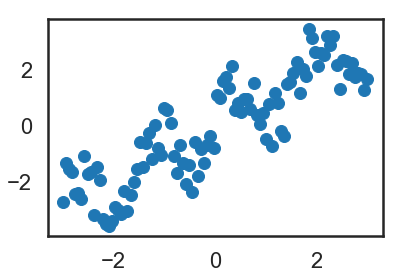

In [4]:
x = np.linspace(-3, 3, 100)            # one hundred points between x=-3 and x=3
rng = np.random.RandomState(42)        # Initialize a random state
scatter = rng.uniform(low=-1., high=1., size=len(x))   # Scatter is uniformly distributed between -1 and 1 
y = np.sin(4 * x) + x + scatter        # Introduce dependence and uniform 
plt.plot(x, y, 'o');                   # Let's have a look!

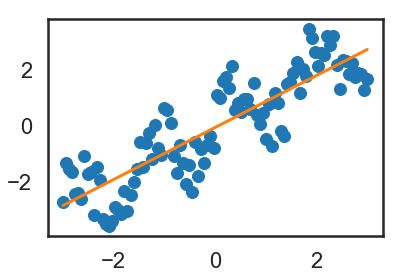

In [5]:
# a typical way of performing a linear fit
from scipy.optimize import curve_fit

def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

A,B = curve_fit(f, x, y)[0] # your data x, y to fit

xlin = np.array([-3,3])
plt.plot(x, y, 'o');   
plt.plot(xlin, f(xlin, A,B))

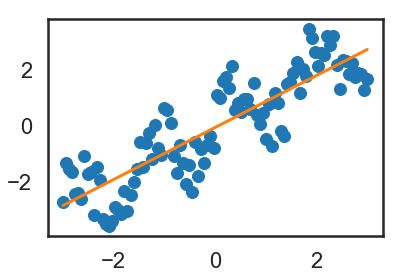

In [6]:
#or do a linear regression fit using sklearn
X = x[:,np.newaxis] # x needs to be 2d for LinearRegression
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)  

ylin = reg.predict(xlin[:, np.newaxis])
plt.plot(x, y, 'o');   
plt.plot(xlin, f(xlin, A,B))

In [7]:
#get the R^2 "score"
print( reg.score(X, y))

0.7517090911724181


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((75, 1), (25, 1), (75,), (25,))

In [9]:
#Let's train the linear regression on the train set and see what score it gets on both train and test sets
reg_train = LinearRegression().fit(X_train, y_train) 
reg_train.score(X_train,y_train), reg_train.score(X_test,y_test)

(0.7600415421875556, 0.6986929672816137)

0.9172788648573131
0.8622739645354347


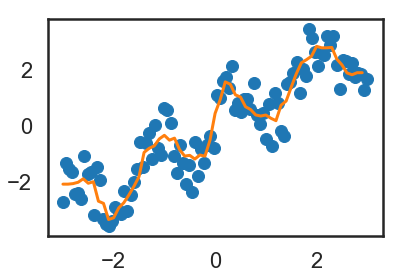

In [10]:
#Now let's do something fancier and do a K-neighbours fit
from sklearn.neighbors import KNeighborsRegressor
#perform the fit
KNR = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

print( KNR.score(X_train, y_train))
print( KNR.score(X_test, y_test))

xplot = np.arange(-3,3,step=0.1)
yKNR = KNR.predict(xplot[:,np.newaxis])
plt.plot(x, y, 'o'); 
plt.plot(xplot, yKNR)

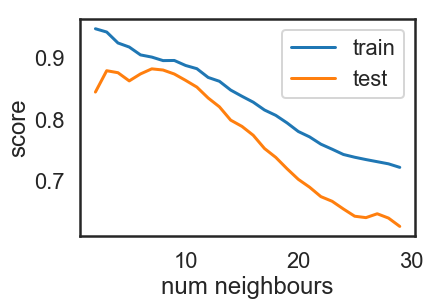

In [11]:
#above the score for the training set it much higher than the test set, which could indicate overfitting.
#Let's tune the hyperparameter n_neighbours to try to optimize the fit

neighbours_to_try = np.arange(2,30)
score_train = np.zeros(len(neighbours_to_try))
score_test = np.zeros(len(neighbours_to_try))
for iter, try_num_neighbours in enumerate(neighbours_to_try):
    KNR = KNeighborsRegressor(n_neighbors=try_num_neighbours).fit(X_train, y_train)
    score_train[iter] = KNR.score(X_train, y_train)
    score_test[iter] = KNR.score(X_test, y_test)

plt.plot( neighbours_to_try, score_train, label='train')
plt.plot( neighbours_to_try, score_test, label='test')
plt.xlabel('num neighbours')
plt.ylabel('score')
plt.legend()

0.8873400714489975
0.8631339440426142


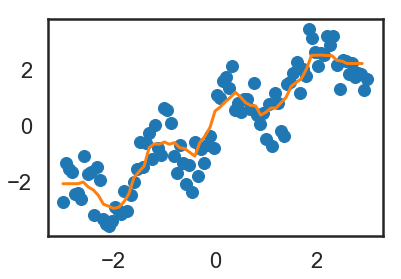

In [12]:
#looks like a sweet spot of around 10 neighbours gives us the maximum score without overfitting the training set, cool!
#so redoing the fit with 10 neighbours:
KNR = KNeighborsRegressor(n_neighbors=10).fit(X_train, y_train)

print( KNR.score(X_train, y_train))
print( KNR.score(X_test, y_test))

xplot = np.arange(-3,3,step=0.1)
yKNR = KNR.predict(xplot[:,np.newaxis])
plt.plot(x, y, 'o'); 
plt.plot(xplot, yKNR)

0.8486383206536086
0.8233841164248596


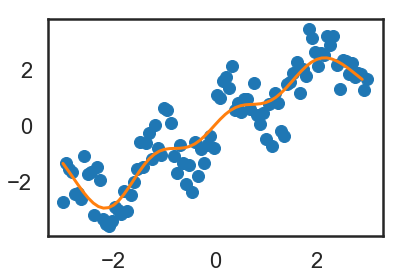

In [13]:
# 1B: same but using support vector machine regression
from sklearn.svm import SVR
clf = SVR()#(C=1.0, epsilon=0.1) default
myfit = clf.fit(X_train, y_train) 

print( myfit.score(X_train, y_train))
print( myfit.score(X_test, y_test))

xplot = np.arange(-3,3,step=0.1)
yfit = myfit.predict(xplot[:,np.newaxis])
plt.plot(x, y, 'o'); 
plt.plot(xplot, yfit)

In [14]:
#let's do a grid search to find optimal hyperparams C and epsilon
#search around the default values
num_points = 50
C_vals = np.logspace(-3,3,num=num_points)*1.0
eps_vals = np.logspace(-3,3,num=num_points)*0.1

CC, ee = np.meshgrid(C_vals, eps_vals, indexing='ij')
score_train = np.zeros([num_points, num_points])
score_test = np.zeros([num_points, num_points])

for iter, C_try in enumerate(C_vals):
    for jiter, eps_try in enumerate(eps_vals):
        clf = SVR(C=C_try, epsilon=eps_try)
        myfit = clf.fit(X_train, y_train) 
        score_train[iter,jiter] = myfit.score(X_train, y_train)
        score_test[iter,jiter] = myfit.score(X_test, y_test) 

score_train[score_train<0] = np.NaN
score_test[score_test<0] = np.NaN
     
best_score = np.amax(score_test)

best_vals = np.argmax(score_test)

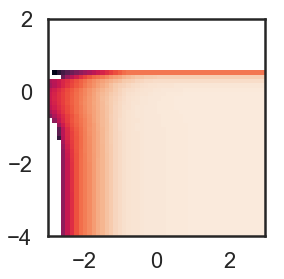

In [15]:

extent=[np.min(np.log10(C_vals)), np.max(np.log10(C_vals)), np.min(np.log10(eps_vals)), np.max(np.log10(eps_vals))]
plt.imshow(np.log10(score_train.T), extent=extent,origin='lower',interpolation = 'nearest')

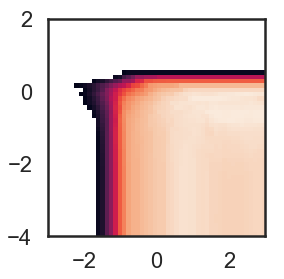

In [16]:
plt.imshow(score_test.T, extent=extent,origin='lower',interpolation = 'nearest')

In [17]:
print( np.nanmax(score_test.flatten()))

best_vals = np.nanargmax(score_test.flatten())
C_best = CC.flatten()[best_vals]
eps_best = ee.flatten()[best_vals]
print(C_best, eps_best)

0.8961387103195148
1000.0 0.2023589647725158


0.9095121651273925
0.8961387103195148


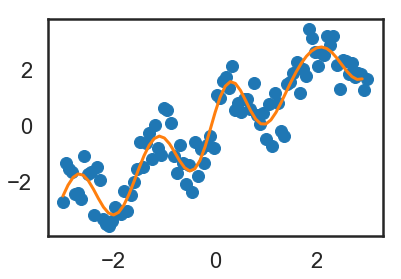

In [18]:
#use the best values
clf = SVR(C=C_best, epsilon=eps_best)
myfit = clf.fit(X_train, y_train) 

print( myfit.score(X_train, y_train))
print( myfit.score(X_test, y_test))

xplot = np.arange(-3,3,step=0.1)
yfit = myfit.predict(xplot[:,np.newaxis])
plt.plot(x, y, 'o'); 
plt.plot(xplot, yfit)

In [19]:
#let's try some other regressions:
from sklearn.linear_model import Lasso, ARDRegression, RANSACRegressor

0.6760094243059511
0.608226752665963


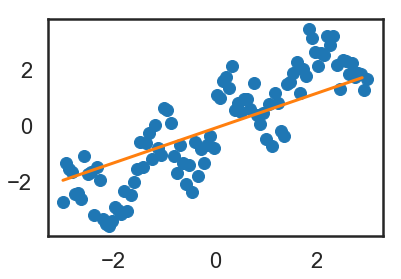

In [20]:
model = Lasso(alpha=1.0) #hyperparam alpha = 1.0 by default. If 0, same as regular linear regression.
#seems like alpha=0 gives the best fit actually, so Lasso model is probably a poor choice for this problem. Also lots of variation in scores when varying train/test split.
#model = ARDRegression() #has 4 hyperparams alpha_1, alpha_2, lambda_1, lambda_2. Gets pretty consistent score when varying train/test split
#this one is problay a nightmare to tune hyperparams because there are so many.
#model = RANSACRegressor() #not sure what the hyperparameters are, if any. score varies strongly depending on train/test split

myfit = model.fit(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)
print( myfit.score(X_train, y_train))
print( myfit.score(X_test, y_test))

xplot = np.arange(-3,3,step=0.1)
yfit = myfit.predict(xplot[:,np.newaxis])
plt.plot(x, y, 'o'); 
plt.plot(xplot, yfit)


In [21]:
#bonus: create dataset with 45 dimensions and 1million data points and compare these methods
ndims=45
nexamples = 1000
rng = np.random.RandomState(42)        # Initialize a random state
X = rng.uniform(low=-3, high=3, size=(nexamples,ndims)) # make it 45-dimensional       
scatter = rng.uniform(low=-3., high=3., size=nexamples)   # Scatter is uniformly distributed between -1 and 1 
coeffs = rng.uniform(low=-0.5, high=0.5, size=ndims)
y = np.sin(4*X[:,0]) + np.sum(X*coeffs, axis=1) + scatter
#y = np.sin(4 * x) + x + scatter        # Introduce dependence and uniform 
y.shape, X.shape

((1000,), (1000, 45))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((750, 45), (250, 45), (750,), (250,))

In [23]:
myfit = LinearRegression().fit(X_train, y_train) 
myfit.score(X_train,y_train), myfit.score(X_test,y_test)

(0.8151153569689994, 0.7170431077634594)

In [24]:
#try knn: seems a lot heavier than linear regression was
#perform the fit
KNR = KNeighborsRegressor(n_neighbors=12).fit(X_train, y_train)

print( KNR.score(X_train, y_train))
print( KNR.score(X_test, y_test))

0.49666117621732975
0.37526826206410513


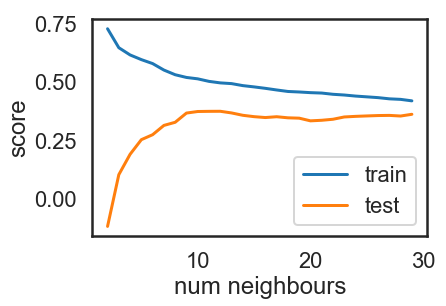

In [25]:
#this takes a really long time. Wouldn't finish on my laptop with a million examples. 
#Seems like 12 neighbours is a good sweetspot though. still underperforms relative to linear regression
neighbours_to_try = np.arange(2,30)
score_train = np.zeros(len(neighbours_to_try))
score_test = np.zeros(len(neighbours_to_try))
for iter, try_num_neighbours in enumerate(neighbours_to_try):
    KNR = KNeighborsRegressor(n_neighbors=try_num_neighbours).fit(X_train, y_train)
    score_train[iter] = KNR.score(X_train, y_train)
    score_test[iter] = KNR.score(X_test, y_test)

plt.plot( neighbours_to_try, score_train, label='train')
plt.plot( neighbours_to_try, score_test, label='test')
plt.xlabel('num neighbours')
plt.ylabel('score')
plt.legend()

In [29]:
#again try some other models

#model = Lasso(alpha=1.0) #hyperparam alpha = 1.0 by default. If 0, same as regular linear regression.
# ---> Fast to run but still seems like alpha=0 gives highest score
model = ARDRegression() #has 4 hyperparams alpha_1, alpha_2, lambda_1, lambda_2. 
# ---> Much slower than linear regression, heating up my laptop something fierce, 
# ---> gives pretty much identical result as linear regression
#model = RANSACRegressor() #not sure what the hyperparameters are, if any. 
# ---> Fast but poorer scores than linear regression
myfit = model.fit(X_train, y_train)

print( myfit.score(X_train, y_train))
print( myfit.score(X_test, y_test))


0.8146206406414261
0.7201630857519812
